# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In this project we will use the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. 

The following code fetches the MNIST dataset:

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version= 1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:
    
* A DESCR key
* A data key containing an array with one row per instance and one column per feature
* A target key containing an array with labels

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

There are 70,000 images, and each image has 784 features. This is beacuse each image is 28 x 28 pixels. Let's take a peak at one digit from the dataset.

Saving figure some_digit_plot


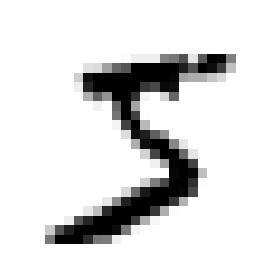

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [8]:
y[0]

'5'

Let's cast y to integer: 

In [9]:
y = y.astype(np.uint8)

**Train and test split**

The MNIST dataset is actually already split into a training set (the fisrt 60,000 images) and a test set (the last 10,000 images):

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar.

# Training a Binary Classifier

Let's simplify the problem for now and only try identify one digit - for example, the number 5. Ths "5-detector" will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. 
Let's create the target vectors for this classification task:


In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Let's pick a classifier and train it, for example the Stochastic Gradient Descent (SGD) classifier. This classifier has the advantage of being capable of handling very large datasets efficiebtly.

In [12]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5:
    

In [13]:
sgd.predict([some_digit])

array([ True])

Looks like it guessed right in this particular case! Let's evaluate the model's performace.

**Implementing Cross-Validation**

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits =3, shuffle=True, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_hat = clone_clf.predict(X_test_folds)
    n_correct = sum(y_hat == y_test_folds)
    print(n_correct / len(y_hat))

0.9669
0.91625
0.96785


Let's use cross_val_score() function to evaluate our SGDClassifier model, using K-fold cross-validation with 3 folds.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_5, cv =3 , scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy on all cross-val folds? This looks amazing, doesn't it? Let's look at a very dumb classifier that just classifies every single image in the not-5 class:  

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y= None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv =3 , scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

What? It has over 90% accuracy? 

This is simply because only about 10% of the images are 5s, so if you always guess that an image is not 5, you will be right about 90% of the time.

**Confusion matrix**

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of a class A are classified as class B.

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

The first row of the matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (true negatives), while the remaining 687 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1891 were wrongly classified as non-5s (false negatives), while the remaining 3530 were corectly classified as 5s ( true positives).

A perfect classifier would have only true positives and true negatives:

In [20]:
y_train_perfect_pred = y_train_5
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives us a lot of information, but sometimes we may want a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier.


precision = TP/(TP+FP)

TP-true positive

FP-false positive

But this would not very useful, since the classifier would ignore all but one positive instance. So precision is typically used along with another metric called recall or sensitivity or the true positive rate (TPR):

recall = TP/(TP+FN)

FN-false negatives

**Precision and Recall**


In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

So, our 5-detector claims an image represents a 5 with a 83% acuraccy and only detects 65% of the 5s.

It is often convinient to combine the precision with the recall into a single metric called the F1 score. The F1 score is the harmonic mean of precision and recall. 

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

**Precision/Recall Trade-off**

For each instance, the SGDClassifier computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the possitive class; otherwise it assigns it to the negative class. Suppose the decision threshold is positioned in the middle. If you raise the threshold, the precision is increasing, but the recall is decreasing. Conversely, lowering the threshold increases recall and reduces precision.

Scikit-Learn doesn't let you set the threshold decision, but it gives us access to the decision scores that it uses to make predictions.

In [24]:
y_scores = sgd.decision_function([some_digit])
y_scores

array([2164.22030239])

The SGDClassifier uses a threshold equal to 0, so let's raise the threshold:

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred 

array([False])

This confirms that raising the threshold decreases recall. The image is actually a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000.

How to decide which threshold to use? We will compute the precision and recall for all possible thresholds:

In [26]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv = 3, 
                            method= "decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


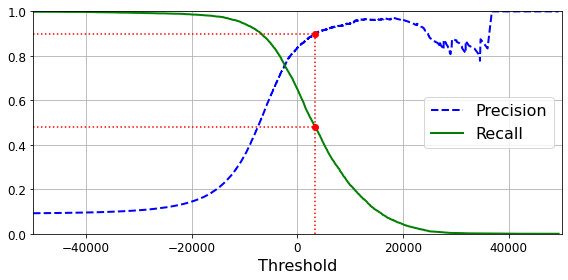

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                         
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                         
save_fig("precision_recall_vs_threshold_plot")                                         
plt.show()

Another way to select a good pecision/recall trade-off is to plot directly agaings recall:

Saving figure precision_vs_recall_plot


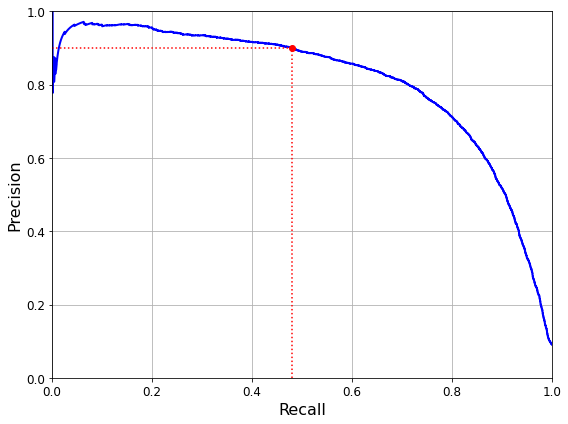

In [29]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

We can see that precision really stars to fall sharply around 80% recall. We will probably want to select a precision/recall trade-off just before that drop - at around 60% recall. 

**The ROC Curve**

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


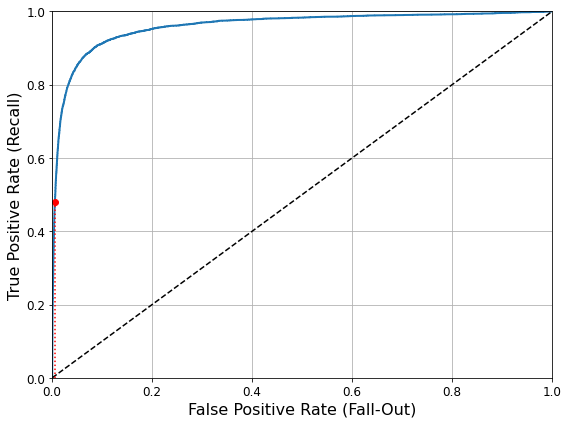

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") 
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line (toward the top-left corner).

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let's now train a RandomForestClassifier and compare its ROC Curve and ROC AUC score to those of the SGDClassifier.

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)
y_probas_rf = cross_val_predict(rf,X_train, y_train_5, cv=3, method = "predict_proba")

In [34]:
y_scores_rf = y_probas_rf[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, y_scores_rf)

Saving figure roc_curve_comparison_plot


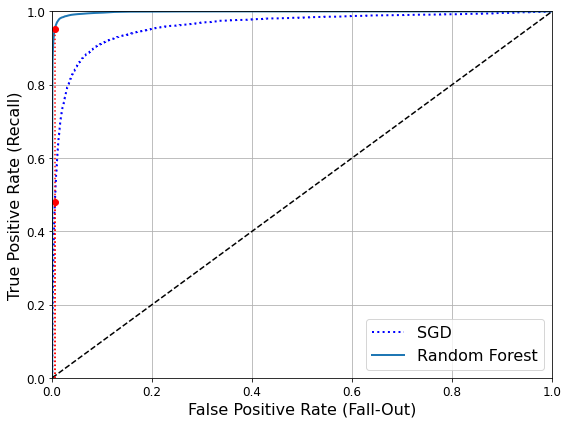

In [35]:
recall_for_forest = tpr_rf[np.argmax(fpr_rf >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

The RandomForestClassifier's ROC curve looks much better than the SGDClassifier's.

In [36]:
roc_auc_score(y_train_5, y_scores_rf)

0.9983436731328145

In [37]:
y_train_pred_forest = cross_val_predict(rf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [38]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

We obtained a 99% precision and a 86.6% recall. Not too bad!

Now let's detect more than just the 5s!

# Multiclass Classification

Let's try to use a Support Vector Machine classifier:


In [39]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)
svm.predict([some_digit])

array([5], dtype=uint8)

This code trains the SVC on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes(y_train_5). Then it makes a prediction (a good one in this case).

In [40]:
some_digit_scores = svm.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

The highest score is indeed the one coresponding to 5.

In [41]:
np.argmax(some_digit_scores)

5

In [42]:
svm.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [44]:
svm.classes_[5]

5

Let's try a one-versus-the-rest approach:

In [45]:
from sklearn.multiclass import OneVsRestClassifier
ovr = OneVsRestClassifier(SVC())
ovr.fit(X_train, y_train)
ovr.predict([some_digit])

array([5], dtype=uint8)

In [46]:
len(ovr.estimators_)

10

Let's try a SGDClassifier:

In [47]:
sgd.fit(X_train, y_train)
sgd.predict([some_digit])

array([3], dtype=uint8)

In [48]:
sgd.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

We see that the SGDClassifier predict the 'some_digit' wrong.

**Evaluate the classfier**

We will use the cross_val_score() function to evaluate the SGDClassifier's accuracy:

In [49]:
cross_val_score(sgd,X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

It gets over 85% on all test folds. If we used a random classifier, you would get 10% accuracy, so this is not such a bad score, but we can still do much better simply by scaling the inputs (increases accuracy above 89%):

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd,X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

**Error Analysis**

We will asume that we have found a promising model and we want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

In [53]:
y_train_pred = cross_val_predict(sgd, X_trained_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

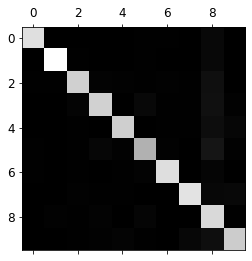

In [54]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

This confusion matrix looks preatty good, since most images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that  there are fewer images of 5s in the dataset or that the classifier does not perform  as well on 5s as on other digits.

Let's focus on the errors. First, we need to divide each value in the confusion matrix by the number of images in the corresponding class so that we can compare error rates instead of absolute number of errors.

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

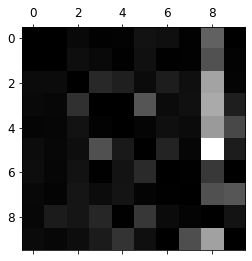

In [58]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()


We can clearly see the kinds of errors the classifier makes. The column for class 8 is quite bright, which tells us that many images get missclassified as 8s. As we can see, the confusion matrix is not necessarily symmetrical. We can also see that 3s and 5s often get confused.

Analyzing individual errors can be a good way to gain insights on what our classifier is doing and why it is failing, but is more difficult and time-consuming. For example, let's plot examples of 3s and 5s:

In [60]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

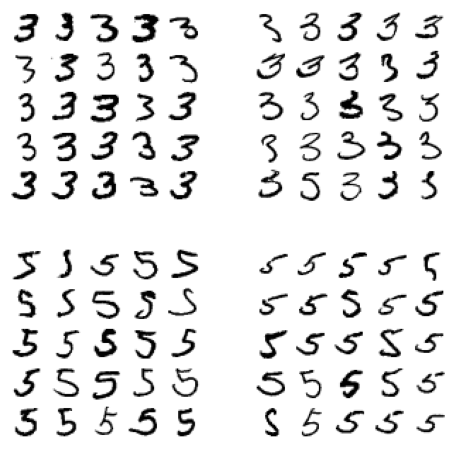

In [62]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred== cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred== cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred== cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred== cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel Classification

In [64]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7,8 or 9), and the second indicates whether or not it is odd.

In [65]:
knn.predict([some_digit])

array([[False,  True]])

And it gets it right! The digit 5 is indeed not large and odd.

In [66]:
y_train_knn_pred = cross_val_predict(knn, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

0.976410265560605

In [67]:
f1_score(y_multilabel, y_train_knn_pred, average = 'weighted')

0.9778357403921755

# Multioutput Classification

Let's  build a system that removes the noise from images. It will take as input a noisy digit image , and it will hopefully output a clean digit image, represented as an array of pixel intensities, just like the MNIST images.

In [68]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise 
y_train_mod = X_train
y_test_mod = X_test

In [71]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

Saving figure noisy_digit_example_plot


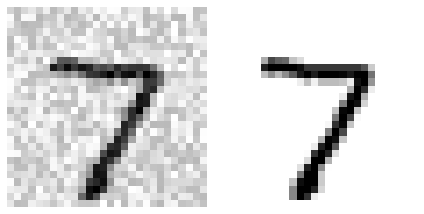

In [72]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

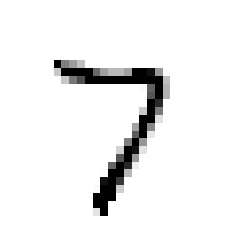

In [73]:
knn.fit(X_train_mod, y_train_mod )
clean_digit = knn.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

**Looks close enough to the target!**

# Task

Try to buid a classifier for the MNIST dataset that achives over 97% accuracy on the test set.


**The following code is too powerful for my pc so i will let you run it... :)**

In [ ]:
from sklearn.model_selection import GridSearchCV
 
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors' : [3,5,11,19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidian', 'manhattan']
}
gs = GridSearchCV(knn, param_grid, verbose =1, cv =3, n_jobs=-1)
gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

In [ ]:
gs.best_score_

In [ ]:
from sklearn.metrics import accuracy_score
y_hat = gs.predict(X_test)
accuracy_score(y_test, y_hat)